# 参照 Reference
- [pip prophet](https://pypi.org/project/prophet/)
- PROPHET document [Trend Changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html)
- [【トリビアのDelta Lake】#4 Spark DataFrameの変換チートシートを作りました](https://qiita.com/yuulian/items/836fad4aab6c7cf19ed1)

# Trend Changepoints トレンドの変化点
このドキュメントの前の例で、実時間系列が頻繁にその軌道に急激な変化を持つことにお気づきかもしれません。デフォルトでは、Prophetはこのようなチェンジポイントを自動的に検出し、トレンドを適切に適応させます。しかし、このプロセスをより細かくコントロールしたい場合（例えば、Prophetがレートの変化を見逃している、あるいは履歴のレートの変化をオーバーフィットしているなど）、いくつかの入力引数を使用することができます。

## プロフェットにおけるチェンジポイントの自動検出
Prophetはまず、レートが変化する可能性のある多くの変化点を指定することで変化点を検出します。これは本質的に、プロフェットはレートが変化する可能性のある場所を多数持っているが、その中で可能な限り少ない場所を使用することを意味します。クイックスタートのPeyton Manning予想を考えてみましょう。デフォルトでは、Prophetは時系列の最初の80%に一様に配置される25の変化点を指定しています。この図の縦線は変化点の位置を示しています：

![image01](https://facebook.github.io/prophet/static/trend_changepoints_files/trend_changepoints_4_0.png)

レートが変化する可能性のある場所がたくさんあるにもかかわらず、事前分布が疎なため、これらの変化点のほとんどは使われていない。これは、各変化点におけるレート変化の大きさをプロットすることでわかる：

![image02](https://facebook.github.io/prophet/static/trend_changepoints_files/trend_changepoints_6_0.png)

潜在的な変化点の数は引数`n_changepoints`を使って設定できるが、これは正則化を調整することでよりよく調整される。シグニフィケーションのチェンジポイントの位置は次のようにして視覚化できる：

In [1]:
import pyspark
from delta import *
from delta.tables import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
from prophet import Prophet

from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
  .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
  .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

:: loading settings :: url = jar:file:/home/vscode/.local/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vscode/.ivy2/cache
The jars for the packages stored in: /home/vscode/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0756b1c6-6806-4909-961c-0de949016076;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.0.0 in central
	found io.delta#delta-storage;3.0.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 103ms :: artifacts dl 4ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.0.0 from central in [default]
	io.delta#delta-storage;3.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0 

In [2]:
workspace = "/workspace"
file_name = "example_wp_log_peyton_manning"
file_ext = ".csv"
data_path = workspace + "/try_prophet/data/" + file_name + file_ext
delta_table_name = "peyton_manning"
delta_table_path = workspace + "/tables/" + delta_table_name
cap_max_value = 8.5
cap_min_value = 6
cap_floor_value = 1.5

In [3]:
# トレーニングデータセットの構造
peyton_manning_schema = StructType([
  StructField('ds', DateType()),
  StructField('y', FloatType())
  ])

# トレーニングファイルをデータフレームに読み込み
peytonDf = spark.read\
  .option("delimiter", ",")\
  .option("header", "true")\
  .schema(peyton_manning_schema)\
  .csv(data_path)

# データフレームをPandas形式に変換する
pandasDf = peytonDf.toPandas()

print("----------------------------------------------------------------------------------------")
print("データを表示")
print("----------------------------------------------------------------------------------------")
pandasDf.head()

----------------------------------------------------------------------------------------
データを表示
----------------------------------------------------------------------------------------


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072468
4,2007-12-14,7.893572


In [4]:
m = Prophet()   # インスタンスを作成する ロジスティック成長を指定する
m.fit(pandasDf) # fitメソッドで学習する

07:14:16 - cmdstanpy - INFO - Chain [1] start processing
07:14:17 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
future = m.make_future_dataframe(periods=1826) # 予測用のデータフレームを指定期間分作成する。
future.tail()                                  # 中身の確認

,ds
4726,2021-01-15
4727,2021-01-16
4728,2021-01-17
4729,2021-01-18
4730,2021-01-19


In [6]:
forecast = m.predict(future) # predictメソッドで予測を行う
forecast.tail()              # 中身の確認

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4726,2021-01-15,5.688489,2.250864,11.245182,1.477183,10.212355,0.900212,0.900212,0.900212,-0.069579,-0.069579,-0.069579,0.969790,0.969790,0.969790,0.0,0.0,0.0,6.588701
4727,2021-01-16,5.687462,2.062726,10.889956,1.470588,10.217046,0.680105,0.680105,0.680105,-0.311709,-0.311709,-0.311709,0.991814,0.991814,0.991814,0.0,0.0,0.0,6.367567
4728,2021-01-17,5.686436,2.532663,11.234991,1.463993,10.221738,1.061181,1.061181,1.061181,0.048288,0.048288,0.048288,1.012893,1.012893,1.012893,0.0,0.0,0.0,6.747617
4729,2021-01-18,5.685409,2.865405,11.481029,1.457398,10.226429,1.385116,1.385116,1.385116,0.352291,0.352291,0.352291,1.032825,1.032825,1.032825,0.0,0.0,0.0,7.070526
4730,2021-01-19,5.684383,2.549715,11.447491,1.450804,10.231121,1.171001,1.171001,1.171001,0.119636,0.119636,0.119636,1.051365,1.051365,1.051365,0.0,0.0,0.0,6.855384


/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


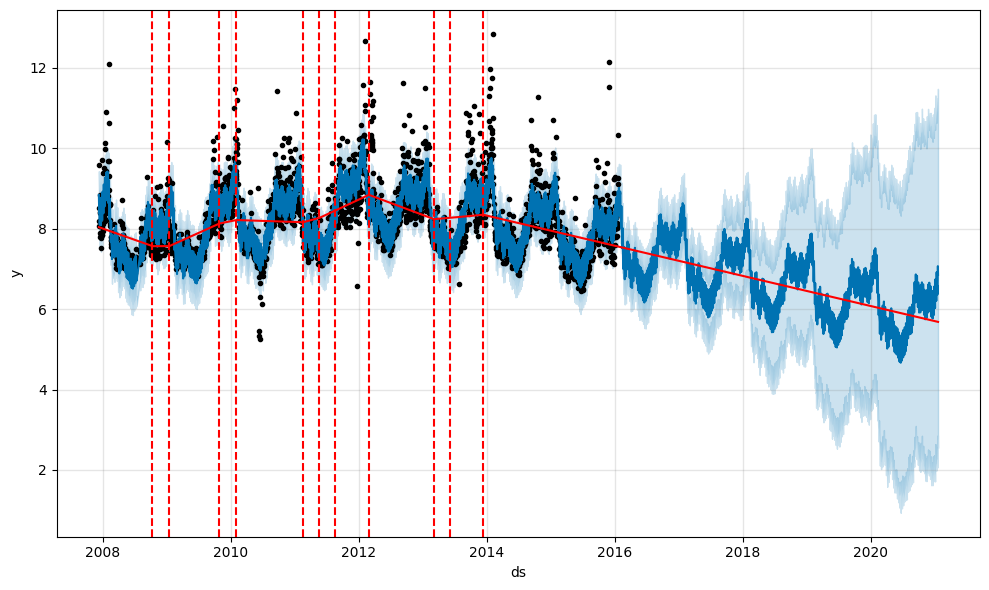

In [7]:
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

デフォルトでは、トレンドの前方への投影のための十分なランウェイを持ち、時系列の末端でのオーバーフィッティングの変動を避けるために、時系列の最初の80%に対してのみチェンジポイントが推論されます。このデフォルトは多くの状況で機能しますが、全てではありません。例えば、Pythonでは`m = Prophet(changepoint_range=0.9)`、Rでは`m <- prophet(changepoint.range = 0.9)`は、時系列の最初の90%に潜在的な`チェンジポイント`を置きます。

## トレンドの柔軟性の調整
トレンド変化がオーバーフィット（柔軟性が高すぎる）またはアンダーフィット（柔軟性が足りない）場合、入力引数`changepoint_prior_scale`を使用してスパース事前分布の強さを調整できます。デフォルトでは、このパラメータは0.05に設定されています。これを増やすとトレンドがより柔軟になります：

07:14:17 - cmdstanpy - INFO - Chain [1] start processing
07:14:18 - cmdstanpy - INFO - Chain [1] done processing
/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


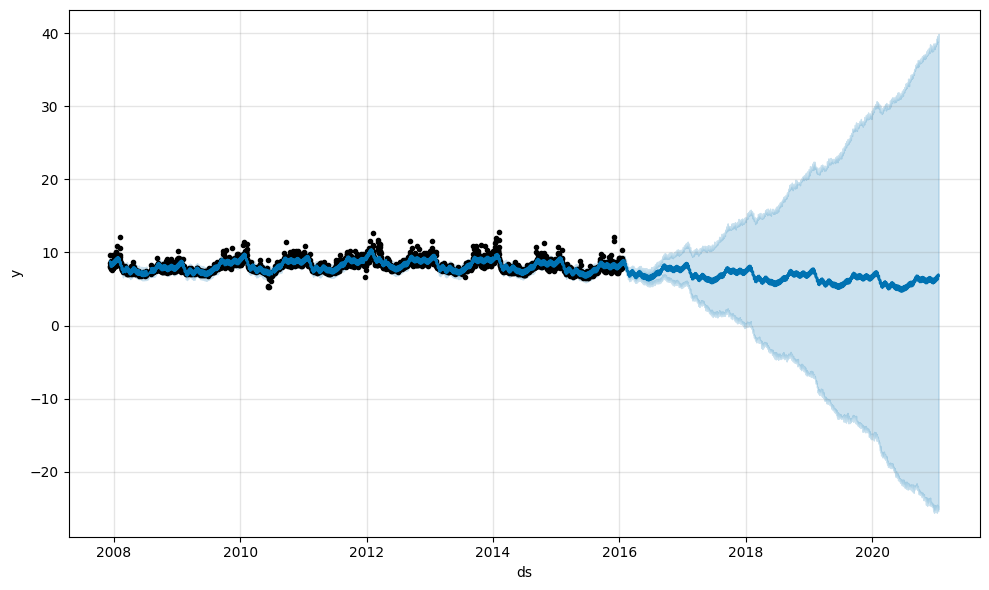

In [8]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(pandasDf).predict(future)
fig2 = m.plot(forecast)

これを減らすと、トレンドの柔軟性が低下する：

07:14:19 - cmdstanpy - INFO - Chain [1] start processing
07:14:19 - cmdstanpy - INFO - Chain [1] done processing
/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


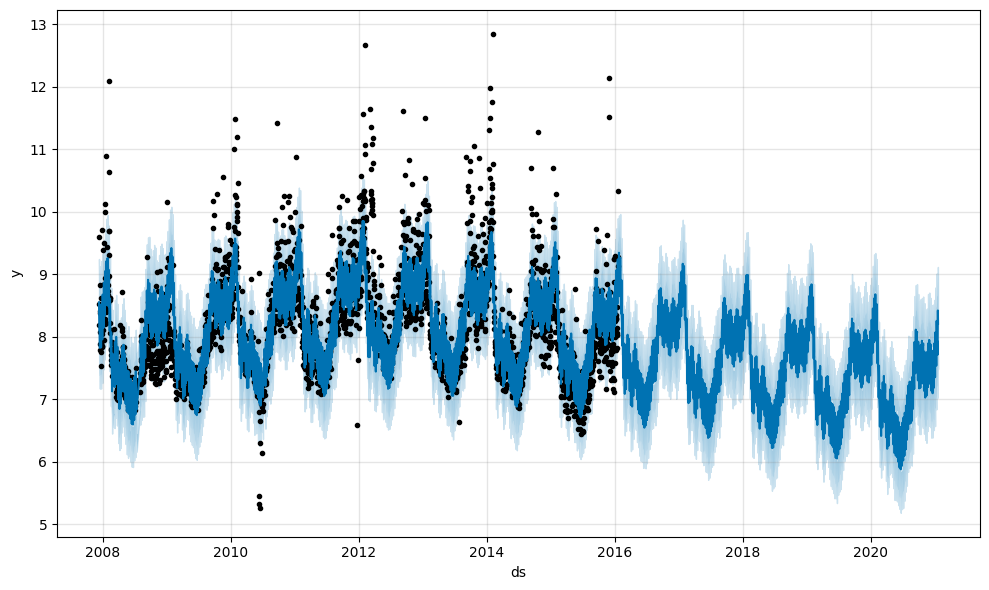

In [9]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(pandasDf).predict(future)
fig3 = m.plot(forecast)

予測を可視化するとき、トレンドが過不足なくフィットしているようであれば、このパラメータは必要に応じて調整できます。完全に自動化された設定では、このパラメータの調整方法に関する推奨事項については、クロス・バリデーションに関するドキュメントを参照してください。

## チェンジポイントの位置の指定
もし必要であれば、自動変化点検出を使用するのではなく、`changepoints`引数で変化点の位置を手動で指定することができます。その場合、勾配の変更はこれらの点でのみ許可され、前と同じようにスパース正則化が適用されます。例えば、自動的に行われるように点のグリッドを作成し、そのグリッドを変更の可能性がある特定の日付で補強することができます。もう一つの例として、ここで行われているように、変化点を小さな日付の集合に完全に限定することもできる：

07:14:20 - cmdstanpy - INFO - Chain [1] start processing
07:14:20 - cmdstanpy - INFO - Chain [1] done processing
/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/vscode/.local/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


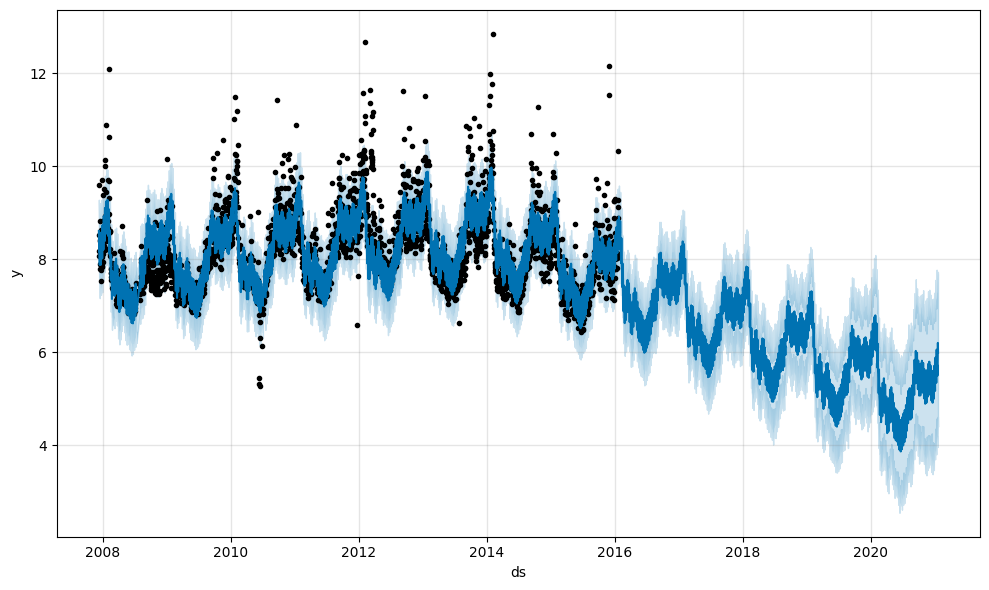

In [10]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(pandasDf).predict(future)
fig4 = m.plot(forecast)